In [20]:
import datetime
import pytz
import numpy as np
import pandas as pd
import time
import random

In [3]:
tsla_df = pd.read_csv('../data/raw/tsla_stock_price.csv')\
                        .drop('Unnamed: 0',axis='columns')
elon_df = pd.read_csv('../data/raw/elonmusk.csv')\
                        .drop('Unnamed: 0',axis='columns')
anomalies_df = pd.read_csv(\
            '../data/processed/anomalyandstock_tagged_tweet_features.csv')\
            .drop('Unnamed: 0',axis='columns')
tsla_df['DateTime'] = pd.to_datetime(tsla_df['DateTime'])
elon_df['Time'] = pd.to_datetime(elon_df['Time'])
anomalies_df['Time'] = pd.to_datetime(anomalies_df['Time'])
anomalies_df['stock_time'] = pd.to_datetime(anomalies_df['stock_time'])
anomaly_only_df = anomalies_df[anomalies_df['anomalous']!=0.]
no_anomaly_df = anomalies_df[anomalies_df['anomalous']!=1.]
print (anomalies_df.shape)
print (anomaly_only_df.shape)

(9708, 33)
(98, 33)


In [286]:
anomaly_only_df.dtypes

username                              object
tweet_id                               int64
reply_to                              object
retweets                               int64
favorites                              int64
hashtags                              object
mentions                              object
text                                  object
permalink                             object
Time                     datetime64[ns, UTC]
hashtags_token                       float64
mentions_token                       float64
reply_to_token                       float64
text_neg                             float64
text_neu                             float64
text_pos                             float64
text_compound                        float64
hashtags_neg                         float64
hashtags_neu                         float64
hashtags_pos                         float64
hashtags_compound                    float64
hour                                   int64
delta_time

In [413]:
poslim = .2
neglim = .2
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
sell_delay = datetime.timedelta(days=1)
buy_delay = datetime.timedelta(days=1)
init_position = 5000.
init_capital = 5000.

In [205]:
datetime.datetime.today()

datetime.datetime(2020, 6, 4, 13, 34, 7, 696530)

In [414]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [32]:
start_date+sell_delay

datetime.datetime(2012, 1, 2, 0, 0, tzinfo=<UTC>)

In [35]:
nearest(tsla_df['DateTime'],start_date)

Timestamp('2011-12-30 00:00:00+0000', tz='UTC')

In [39]:
tsla_df.loc[tsla_df['DateTime'] == nearest(tsla_df['DateTime'],start_date)].index.values[0]

381

In [31]:
type(start_date)

datetime.datetime

In [19]:
type(tsla_df['DateTime'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
hold_df = pd.DataFrame()
hold_df['Time'] = tsla_df['DateTime']
hold_df.head()

,Time
0,2010-06-29 00:00:00+00:00
1,2010-06-30 00:00:00+00:00
2,2010-07-01 00:00:00+00:00
3,2010-07-02 00:00:00+00:00
4,2010-07-06 00:00:00+00:00


In [145]:
anomaly_only_df['Time'].iloc[0] < start_date
true_start_date = nearest(tsla_df['DateTime'],start_date)
start_index = tsla_df.loc[tsla_df['DateTime'] 
                                    == true_start_date].index[0]
print(start_index)

1891


In [49]:
hold_df['position'] = (tsla_df['Open']/tsla_df['Open'].iloc[0])*init_position
hold_df.tail()

,Time,position
5693,2020-06-03 19:35:00+00:00,232821.044922
5694,2020-06-03 19:40:00+00:00,233044.738770
5695,2020-06-03 19:45:00+00:00,233081.584730
5696,2020-06-03 19:50:00+00:00,233081.584730
5697,2020-06-03 19:55:00+00:00,232460.439582


In [99]:
sell_date = tsla_df.loc[tsla_df['DateTime'] == anomaly_only_df['stock_time'].iloc[20]]['DateTime'] + sell_delay
print(anomaly_only_df['stock_time'].iloc[20])
print(sell_date.iloc[0])
tsla_df.loc[tsla_df['DateTime'] == sell_date.iloc[0]].index[0]

2012-11-23 00:00:00+00:00
2012-11-24 00:00:00+00:00


IndexError: index 0 is out of bounds for axis 0 with size 0

In [147]:
hold_df = pd.DataFrame() #initialize 
buy_and_sell_df = pd.DataFrame() #initialize
true_start_date = nearest(tsla_df['DateTime'],start_date) #the closest date with a stock price
start_index = tsla_df.loc[tsla_df['DateTime'] == true_start_date].index[0] #the index of true_start_date
hold_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
buy_and_sell_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
# Position growth scales with Tesla stock price
hold_df['num_shares'] = init_position/tsla_df['Open'].iloc[start_index]
hold_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                       /tsla_df['Open'].iloc[start_index])*init_position
buy_and_sell_df['num_shares'] = init_position/tsla_df['Open'].iloc[start_index]
buy_and_sell_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                               *buy_and_sell_df['num_shares'])
# Capital growth only changes as a result of buy -> sell orders
hold_df['capital'] = init_capital
buy_and_sell_df['capital'] = init_capital

In [148]:
buy_and_sell_df.head()

,Time,num_shares,position,capital
381,2011-12-30 00:00:00+00:00,175.500176,5000.000000,5000.0
382,2012-01-03 00:00:00+00:00,175.500176,5078.975079,5000.0
383,2012-01-04 00:00:00+00:00,175.500176,4950.859951,5000.0
384,2012-01-05 00:00:00+00:00,175.500176,4871.884872,5000.0
385,2012-01-06 00:00:00+00:00,175.500176,4773.604774,5000.0


In [149]:
hold_df.tail()

,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,175.500176,155268.510127,5000.0
5694,2020-06-03 19:40:00+00:00,175.500176,155417.691703,5000.0
5695,2020-06-03 19:45:00+00:00,175.500176,155442.264298,5000.0
5696,2020-06-03 19:50:00+00:00,175.500176,155442.264298,5000.0
5697,2020-06-03 19:55:00+00:00,175.500176,155028.022185,5000.0


In [139]:
i=20
buy_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime']
buy_index = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]].index[0]
buy_price = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]]['Open'].values[0]
sell_date_target = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime'] + buy_delay
#the desired sell date may not be a business day
sell_date = nearest(tsla_df['DateTime'].iloc[buy_index+1:],sell_date_target.iloc[0]) 
sell_index = tsla_df.loc[tsla_df['DateTime'] == sell_date].index[0]
sell_price = tsla_df.loc[tsla_df['DateTime'] == sell_date]['Open'].values[0]
frac_change = sell_price/buy_price #the fractional change in our captial from the transactionuy
print (frac_change)
buy_and_sell_df['capital'].iloc[sell_index:] *= frac_change
buy_and_sell_df.tail()

0.9846625766871165


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,16.025641,14178.204659,4923.312883
5694,2020-06-03 19:40:00+00:00,16.025641,14191.827040,4923.312883
5695,2020-06-03 19:45:00+00:00,16.025641,14194.070865,4923.312883
5696,2020-06-03 19:50:00+00:00,16.025641,14194.070865,4923.312883
5697,2020-06-03 19:55:00+00:00,16.025641,14156.244718,4923.312883


In [157]:
i=20
sell_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime']
print(anomaly_only_df['stock_time'].iloc[i])
print(sell_date)
sell_index = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]].index[0]
sell_price = tsla_df.loc[tsla_df['DateTime'] 
                        == anomaly_only_df['stock_time'].iloc[i]]['Open'].values[0]
print(sell_price)
buy_date_target = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'].iloc[i]]['DateTime'] + sell_delay
print(buy_date_target)
#the desired sell date may not be a business day
buy_date = nearest(tsla_df['DateTime'].iloc[sell_index+1:],buy_date_target.iloc[0]) 
print(buy_date)
#adjust sell_index to buy_and_sell index coords with (- start_index)
buy_index = tsla_df.loc[tsla_df['DateTime'] == buy_date].index[0] - start_index
buy_price = tsla_df.loc[tsla_df['DateTime'] == buy_date]['Open'].values[0]
print(buy_price)
#the change in the number of shares, again adjust sell_index to buy_and_sell 
#index coords with (- start_index) 
new_num_shares = sell_price*(buy_and_sell_df['num_shares']
                             .iloc[sell_index-start_index])/buy_price 
buy_and_sell_df['num_shares'].iloc[buy_index:] = new_num_shares
buy_and_sell_df['position'].iloc[buy_index:]  = new_num_shares*tsla_df['Open']\
                                                                .iloc[buy_index+start_index:]
buy_and_sell_df.tail()

2012-11-23 00:00:00+00:00
606   2012-11-23 00:00:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]
32.6
606   2012-11-24 00:00:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]
2012-11-26 00:00:00+00:00
32.1


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,num_shares,position,capital
5693,2020-06-03 19:35:00+00:00,178.233823,157687.022746,5000.0
5694,2020-06-03 19:40:00+00:00,178.233823,157838.528022,5000.0
5695,2020-06-03 19:45:00+00:00,178.233823,157863.483369,5000.0
5696,2020-06-03 19:50:00+00:00,178.233823,157863.483369,5000.0
5697,2020-06-03 19:55:00+00:00,178.233823,157442.788886,5000.0


In [176]:
anomaly_only_df['Time'][40]

Timestamp('2011-12-31 13:06:23+0000', tz='UTC')

In [295]:
for i in anomaly_only_df.index:
    print (anomaly_only_df['stock_time'][i])

2011-12-01 00:00:00+00:00
2011-12-30 00:00:00+00:00
2012-02-27 00:00:00+00:00
2012-03-21 00:00:00+00:00
2012-05-04 00:00:00+00:00
2012-05-04 00:00:00+00:00
2012-05-04 00:00:00+00:00
2012-05-22 00:00:00+00:00
2012-05-22 00:00:00+00:00
2012-05-22 00:00:00+00:00
2012-05-22 00:00:00+00:00
2012-05-23 00:00:00+00:00
2012-05-24 00:00:00+00:00
2012-05-24 00:00:00+00:00
2012-05-25 00:00:00+00:00
2012-05-25 00:00:00+00:00
2012-06-01 00:00:00+00:00
2012-06-01 00:00:00+00:00
2012-06-01 00:00:00+00:00
2012-07-13 00:00:00+00:00
2012-11-23 00:00:00+00:00
2012-12-03 00:00:00+00:00
2012-12-13 00:00:00+00:00
2013-02-04 00:00:00+00:00
2013-03-04 00:00:00+00:00
2013-03-08 00:00:00+00:00
2013-03-11 00:00:00+00:00
2013-04-03 00:00:00+00:00
2013-04-03 00:00:00+00:00
2013-07-29 00:00:00+00:00
2014-02-14 00:00:00+00:00
2014-04-29 00:00:00+00:00
2016-03-10 00:00:00+00:00
2016-04-04 00:00:00+00:00
2016-06-09 00:00:00+00:00
2017-02-21 00:00:00+00:00
2017-03-28 00:00:00+00:00
2017-03-29 00:00:00+00:00
2017-04-28 0

In [325]:
print (anomaly_only_df['stock_time'])

1      2011-12-01 00:00:00+00:00
40     2011-12-30 00:00:00+00:00
99     2012-02-27 00:00:00+00:00
113    2012-03-21 00:00:00+00:00
141    2012-05-04 00:00:00+00:00
                  ...           
9062   2020-04-09 19:55:00+00:00
9153   2020-04-17 19:55:00+00:00
9326   2020-04-30 14:40:00+00:00
9626   2020-05-18 00:00:00+00:00
9675   2020-05-26 00:00:00+00:00
Name: stock_time, Length: 98, dtype: datetime64[ns, UTC]


In [415]:
#from numba import jit
poslim = .2
neglim = .2
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
sell_delay = datetime.timedelta(days=1)
buy_delay = datetime.timedelta(days=1)
init_position = 5000.
init_capital = 5000.
#@jit()
def asset_strategy_calculation(poslim,neglim,init_position,init_capital,
                                buy_delay,sell_delay,start_date,
                                anomaly_only_df,tsla_df):
    """The buying and selling strategy implementing tweet inforation"""
    hold_df = pd.DataFrame() #initialize 
    buy_and_sell_df = pd.DataFrame() #initialize
    #the closest date with a stock price
    true_start_date = nearest(tsla_df['DateTime'],start_date) 
    #the index of true_start_date
    start_index = tsla_df.loc[tsla_df['DateTime'] == true_start_date].index[0]
    hold_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
    buy_and_sell_df['Time'] = tsla_df['DateTime'].iloc[start_index:] #set dates
    # Position growth scales with Tesla stock price
    hold_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                           /tsla_df['Open'].iloc[start_index])*init_position
    # buy_and sell_df needs to track the number of shares held
    buy_and_sell_df['num_shares'] = init_position/tsla_df['Open']\
                                                    .iloc[start_index]
    # and the value of those shares
    buy_and_sell_df['position'] = (tsla_df['Open'].iloc[start_index:]\
                                   *buy_and_sell_df['num_shares'])
    # Capital growth only changes as a result of buy -> sell orders
    hold_df['capital'] = init_capital
    buy_and_sell_df['capital'] = init_capital
    # Iterate over the anomalies and make trades based on input variables
    for i in anomaly_only_df.index:# we only trade based on tweet anomalies
        #iterate forward through time with the index of anomaly_only_df
        if anomaly_only_df['Time'][i] < start_date: 
            #this anomaly happened before we started trading
            pass
        elif anomaly_only_df['text_compound'][i] < poslim and \
                anomaly_only_df['text_compound'][i] > -neglim : 
            #neutral anomaly, do nothing
            pass
        elif anomaly_only_df['text_compound'][i] >= poslim : 
            # buy first then sell
            buy_date = tsla_df.loc[tsla_df['DateTime'] \
                                   == anomaly_only_df['stock_time'][i]]\
                                   ['DateTime']
            buy_index = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    .index[0]
            buy_price = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    ['Open'].values[0]
            sell_date_target = tsla_df.loc[tsla_df['DateTime'] 
                                           == anomaly_only_df['stock_time'][i]\
                                           ]['DateTime'] + buy_delay
            #the desired sell date may not be a business day
            sell_date = nearest(tsla_df['DateTime'].iloc[buy_index+1:],\
                                                    sell_date_target.iloc[0]) 
            #adjust sell_index to buy_and_sell index units with (- start_index)
            sell_index = tsla_df.loc[tsla_df['DateTime'] == sell_date].\
                                                        index[0] - start_index
            sell_price = tsla_df.loc[tsla_df['DateTime'] == sell_date]\
                                                            ['Open'].values[0]
            #the fractional change in our captial from the transaction
            frac_change = sell_price/buy_price 
            buy_and_sell_df['capital'].iloc[sell_index:] *= frac_change
        elif anomaly_only_df['text_compound'][i] <= -neglim : 
            # sell first then buy
            sell_date = tsla_df.loc[tsla_df['DateTime'] 
                       == anomaly_only_df['stock_time'][i]]['DateTime']
            sell_index = tsla_df.loc[tsla_df['DateTime'] 
                                    == anomaly_only_df['stock_time'][i]]\
                                                                .index[0]
            sell_price = tsla_df.loc[tsla_df['DateTime'] \
                                    == anomaly_only_df['stock_time'][i]]\
                                    ['Open'].values[0]
            buy_date_target = tsla_df.loc[tsla_df['DateTime'] \
                                         == anomaly_only_df['stock_time'][i]]\
                                         ['DateTime'] + sell_delay
            #the desired sell date may not be a business day
            buy_date = nearest(tsla_df['DateTime'].iloc[sell_index+1:],\
                               buy_date_target.iloc[0]) 
            #adjust sell_index to buy_and_sell index units with (- start_index)
            buy_index = tsla_df.loc[tsla_df['DateTime'] == buy_date].index[0]\
                        - start_index
            buy_price = tsla_df.loc[tsla_df['DateTime'] == buy_date]['Open']\
                                    .values[0]
            #the change in the number of shares, again adjust sell_index to 
            #buy_and_sell index coords with (- start_index) 
            new_num_shares = sell_price*(buy_and_sell_df['num_shares']\
                                       .iloc[sell_index-start_index])/buy_price 
            #record the new shares
            buy_and_sell_df['num_shares'].iloc[buy_index:] = new_num_shares 
            #compute the new position
            buy_and_sell_df['position'].iloc[buy_index:] = new_num_shares*\
                                tsla_df['Open'].iloc[buy_index+start_index:]
            
    hold_df['total'] = hold_df['position']+hold_df['capital']
    buy_and_sell_df['total'] = buy_and_sell_df['position']+\
                               buy_and_sell_df['capital']
    #relative performance
    hold_df['relative'] = hold_df['total']/hold_df['total']
    buy_and_sell_df['relative'] = buy_and_sell_df['total']/\
                                  hold_df['total']
    return buy_and_sell_df,hold_df 

In [416]:
%%time
strat_df,hold_df = asset_strategy_calculation(poslim,neglim,init_position,init_capital,\
                                buy_delay,sell_delay,start_date,\
                                anomaly_only_df,tsla_df)

/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 6.8 s, sys: 22 ms, total: 6.82 s
Wall time: 6.86 s


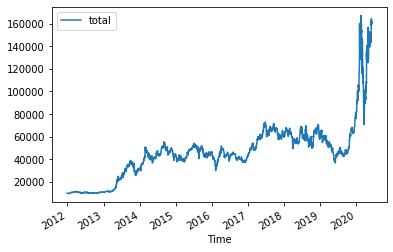

In [417]:
hold_df.plot(x='Time',y='total')

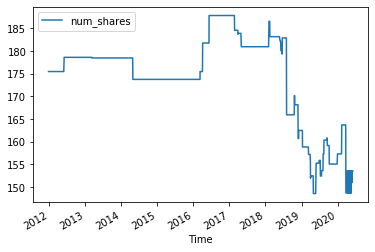

In [418]:
strat_df.plot(x='Time',y='num_shares')

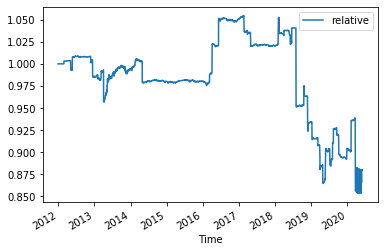

In [419]:
strat_df.plot(x='Time',y='relative')

# Time to make a numpy version of the trading strategy function so that it runs faster than ~8s so we can do some hyper-parameter tuning.

In [249]:
tsla_np = tsla_df[['DateTime','Open']].values
print(tsla_df.columns)
tsla_np.shape


Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Adj Close'],
      dtype='object')


(5698, 2)

In [235]:
anomaly_only_np = anomaly_only_df[['Time','stock_time','text_compound']].values
print (anomaly_only_df[['Time','stock_time','text_compound']].columns)
anomaly_only_np.shape

Index(['Time', 'stock_time', 'text_compound'], dtype='object')


(98, 3)

In [236]:
anomaly_only_np = np.vstack((anomaly_only_df.index,anomaly_only_np.transpose())).transpose()
anomaly_only_np.shape

(98, 4)

Need to test this function to see if it still works

In [264]:
tsla_df.columns

Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Adj Close'],
      dtype='object')

In [323]:
def convert_to_seconds_after_start(start_time,df,time_column):
    """A function to turn the datetime data from the
        pandas data frames to floats for the numpy
        vertion of the asset strategy model."""
    df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
    #returns a numpy array
    result = np.zeros(df.shape[0])
    result = df['temporary'].values
    df.drop(columns=['temporary'])
    return result
#convert datetimes to floats (s after start date)
tsla_time = convert_to_seconds_after_start(start_date,tsla_df,'DateTime')
anomaly_time = convert_to_seconds_after_start(start_date,anomaly_only_df,'Time')
anomaly_stock_time = convert_to_seconds_after_start(start_date,anomaly_only_df,'stock_time')
print (tsla_df.shape)
print (tsa_time.shape)
#strip inputs down to only the necessary entries for numpy array assignment
tsla_np = tsla_df[['DateTime','Open']].values
anomaly_only_np = anomaly_only_df[['Time','stock_time',\
                                   'text_compound']].values
#'index' goes on index 0 
anomaly_only_np = np.vstack((anomaly_only_df.index,\
                             anomaly_only_np.transpose())).transpose()
# write time in (s) to the arrays
tsla_np[:,0] = tsla_time
anomaly_only_np[:,1] = anomaly_time
anomaly_only_np[:,2] = anomaly_stock_time

(5698, 10)


<ipython-input-323-f695c3e7c406>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


NameError: name 'tsa_time' is not defined

In [238]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))

%timeit true_start_date = nearest(tsla_df['DateTime'],start_date)

122 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [292]:
%timeit true_start_date = nearest(tsla_np[:,0],0.) #since times are now measured in seconds beore/after start date

762 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Sweeet, x160 speed up.

In [294]:
%timeit true_start_date = np.min(np.abs(tsla_np[:,0]-0.))

327 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Even better!

In [291]:
#Sanity checks
print (tsla_np[:10,0],tsla_np[-10:,0])
print (anomaly_only_np[:10,1],anomaly_only_np[-10:,1])
print (anomaly_only_np[:10,2],anomaly_only_np[-10:,2])

[-47606400.0 -47520000.0 -47433600.0 -47347200.0 -47001600.0 -46915200.0
 -46828800.0 -46742400.0 -46483200.0 -46396800.0] [265835400.0 265835700.0 265836000.0 265836300.0 265836600.0 265836900.0
 265837200.0 265837500.0 265837800.0 265838100.0]
[-2678400.0 -172800.0 4924800.0 6912000.0 10713600.0 10713600.0 10713600.0
 12268800.0 12268800.0 12268800.0] [252028800.0 255312000.0 255916800.0 259545600.0 259545600.0 261086100.0
 261777300.0 262881600.0 264384000.0 265075200.0]
[-2678400.0 -172800.0 4924800.0 6912000.0 10713600.0 10713600.0 10713600.0
 12268800.0 12268800.0 12268800.0] [252028800.0 255312000.0 255916800.0 259545600.0 259545600.0 261086100.0
 261777300.0 262881600.0 264384000.0 265075200.0]


In [279]:
#let's see if the .total_seconds() method works on timedelta
sell_delay = datetime.timedelta(days=1).total_seconds()
sell_delay

86400.0

Victory! Time to re-jigger the whole function with numpy arrays and numba.

In [283]:
poslim = .2
neglim = .2
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2015,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
sell_delay = datetime.timedelta(days=1)
buy_delay = datetime.timedelta(days=1)
init_position = 5000.
init_capital = 5000.

def apply_rules(index_i,index_j,stock_np,anomaly_np,buy_sell_np,rule,
                buy_delay,sell_delay,start_index,rand_flag = False):
    #This is only for modelling random guessing########
    if rand_flag == True:
        rule = random.choice(['buy','nothing','sell'])
    else:
        pass
    ###################################################
    if rule == 'nothing':
        return buy_sell_np
    elif rule == 'buy':
        # buy first then sell
        buy_date = anomaly_np[index_j,2]
        buy_index = np.argmin(np.abs(stock_np[:,0] - anomaly_np[index_j,2]))
        buy_price = stock_np[buy_index,1]
        sell_date_target = buy_date + buy_delay
        #the desired sell date may not be a business day
        diff = stock_np[:,0] - sell_date_target
        mask = np.ma.less_equal(diff, 0)
        #this will be the index of the true sell date
        sell_index = np.argmin(np.abs(mask))
        if sell_index == 0: #we are off the edge of the map
            #the sell date is after the end of the stock data
            #do nothing and return
            return buy_sell_np
        sell_price = stock_np[sell_index,1]
        #the fractional change in our captial from the transaction
        frac_change = sell_price/buy_price 
        #shift the total capital for all days after the transaction
        #-start_index corrects for offset in indices with stock_np
        buy_sell_np[sell_index - start_index:,3] *= frac_change
        #log the trade attempt
        buy_sell_np[sell_index - start_index,7] = 1.
        #log if the trade was a success
        if frac_change >= 1.:
            buy_sell_np[sell_index - start_index,6] = 1.
        return buy_sell_np
    elif rule == 'sell':
        sell_date = anomaly_np[index_j,2]
        sell_index = np.argmin(np.abs(stock_np[:,0] - anomaly_np[index_j,2]))
        sell_price = stock_np[sell_index,1]
        buy_date_target = sell_date + sell_delay
        #the desired buy date may not be a business day
        diff = stock_np[:,0] - buy_date_target
        mask = np.ma.less_equal(diff, 0)
        #this will be the index of the true buy date
        buy_index = np.argmin(np.abs(mask))
        if buy_index == 0: #we are off the edge of the map
            #the buy date is after the end of the stock data
            #do nothing and return
            return buy_sell_np
        buy_price = stock_np[buy_index,1]
        #the change in the number of shares, again adjust sell_index to 
        #buy_and_sell index coords with (- start_index) 
        new_num_shares = sell_price*(buy_sell_np[sell_index-start_index,1])/buy_price 
        #record the new shares
        #-start_index corrects for offset in indices with stock_np
        buy_sell_np[buy_index - start_index:,1] = new_num_shares 
        #compute the new position
        #-start_index corrects for offset in indices with stock_np
        buy_sell_np[buy_index - start_index:,2] = new_num_shares*stock_np[buy_index:,1]
        #log the trade attempt
        buy_sell_np[buy_index - start_index,7] = 1.
        #log if the trade was a success
        if buy_sell_np[sell_index-start_index,1] <= new_num_shares:
            buy_sell_np[buy_index - start_index,6] = 1.
        return buy_sell_np
    else: #something went wrong
        return buy_sell_np

def convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                buy_delay,sell_delay):
    """Converts dataframes and delta times to numpy arrays and floats."""
    #convert datetimes to floats (s after start date)
    tsla_time = convert_to_seconds_after_start(start_date,tsla_df,'DateTime')
    anomaly_time = convert_to_seconds_after_start(start_date,anomaly_only_df,'Time')
    anomaly_stock_time = convert_to_seconds_after_start(start_date,anomaly_only_df,'stock_time')
    #strip inputs down to only the necessary entries for numpy array assignment
    tsla_np = tsla_df[['DateTime','Open']].values
    anomaly_only_np = anomaly_only_df[['Time','stock_time',\
                                       'text_compound']].values
    #'index' goes on index 0 
    anomaly_only_np = np.vstack((anomaly_only_df.index,\
                                 anomaly_only_np.transpose())).transpose()
    # write time in (s) to the arrays
    tsla_np[:,0] = tsla_time
    anomaly_only_np[:,1] = anomaly_time
    anomaly_only_np[:,2] = anomaly_stock_time
    # Convert the sell_delay and buy_delay to seconds
    sell_delay = sell_delay.total_seconds()
    buy_delay = buy_delay.total_seconds()
    end_time = (end_date - start_date).total_seconds()
    start_time = 0.
    return tsla_np,anomaly_only_np,sell_delay,buy_delay,start_time,end_time

def convert_to_seconds_after_start(start_time,df,time_column):
    """A function to turn the datetime data from the
        pandas data frames to floats for the numpy
        vertion of the asset strategy model."""
    df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
    #returns a numpy array
    result = np.zeros(df.shape[0])
    result = df['temporary'].values
    df.drop(columns=['temporary'])
    return result

tsla_np,anomaly_only_np,sell_delay,buy_delay,start_time,end_time = \
            convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                        buy_delay,sell_delay)
rule_pos = 'buy'
rule_neu = 'nothing'
rule_neg='sell'
def asset_strategy_calculation_numpy(poslim,neglim,init_position,init_capital,\
                                    buy_delay,sell_delay,anomaly_only_np,\
                                    tsla_np,start_time,end_time,rule_pos,\
                                    rule_neu,rule_neg,rand_flag = False):
    """The buying and selling strategy implementing tweet inforation"""
    #the closest date with a stock price
    true_start_date = np.min(np.abs(tsla_np[:,0]-start_time)) 
    #the index of true_start_date
    start_index = np.argmin(np.abs(tsla_np[:,0]-start_time)) 
    hold_np = np.zeros([len(tsla_np[start_index:,0]),8]) #initialize 
    buy_and_sell_np = np.zeros([len(tsla_np[start_index:,0]),8]) #initialize
    hold_np[:,0] = tsla_np[start_index:,0] #set dates
    buy_and_sell_np[:,0] = tsla_np[start_index:,0] #set dates
    # Position growth scales with Tesla stock price
    hold_np[:,2] = (tsla_np[start_index:,1]\
                           /tsla_np[start_index,1])*init_position
    # hold_np does not need to track the number of shares held
    hold_np[:,1] = init_position/tsla_np[start_index,1]
    # buy_and sell_np needs to track the number of shares held
    buy_and_sell_np[:,1] = init_position/tsla_np[start_index,1]
    # and the value of those shares
    buy_and_sell_np[:,2] = (tsla_np[start_index,1]*buy_and_sell_np[:,1])
    # Capital growth only changes as a result of buy -> sell orders
    hold_np[:,3] = init_capital
    buy_and_sell_np[:,3] = init_capital
    # Iterate over the anomalies and make trades based on input variables
    j = 0 #iteration variable for anomaly_only_np
    # i is the index of the stock_np time
    for i in anomaly_only_np[:,0]:# we only trade based on tweet anomalies
        #iterate forward through time with the index of anomaly_only_df
        if anomaly_only_np[j,2] < start_time: 
            #this anomaly happened before we started trading
            #do nothing
            pass
        elif anomaly_only_np[j,2] > end_time:
            #this anomaly happens after we're done trading
            #do nothing
            pass
        elif anomaly_only_np[j,3] <= poslim and \
                anomaly_only_np[j,3] >= -neglim : #we have a neutral anomaly
            #apply defined trading rule
            buy_and_sell_np = apply_rules(i,j,tsla_np,anomaly_only_np,\
                                          buy_and_sell_np,rule_neu,\
                                          buy_delay,sell_delay,\
                                          start_index,rand_flag)
        elif anomaly_only_np[j,3] >= poslim : #we have a positive anomaly
            #apply defined trading rule
            buy_and_sell_np = apply_rules(i,j,tsla_np,anomaly_only_np,\
                                          buy_and_sell_np,rule_pos,\
                                          buy_delay,sell_delay,\
                                          start_index,rand_flag)
            
        elif anomaly_only_np[j,3] <= -neglim : 
            # apply defined trading rule
            buy_and_sell_np = apply_rules(i,j,tsla_np,anomaly_only_np,\
                                          buy_and_sell_np,rule_neg,\
                                          buy_delay,sell_delay,\
                                          start_index,rand_flag)
        j += 1 #increment the anomaly index
            
            
    hold_np[:,4] = hold_np[:,2]+hold_np[:,3]
    buy_and_sell_np[:,4] = buy_and_sell_np[:,2]+buy_and_sell_np[:,3]
    #relative performance
    hold_np[:,5] = hold_np[:,4]/hold_np[:,4]
    buy_and_sell_np[:,5] = buy_and_sell_np[:,4]/hold_np[:,4]
    return buy_and_sell_np,hold_np

<ipython-input-283-315a42f41542>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


In [269]:
%timeit bnh,honly = asset_strategy_calculation_numpy(poslim,neglim,init_position,init_capital,\
                                    buy_delay,sell_delay,anomaly_only_np,\
                                    tsla_np,start_time,end_time,rule_pos,\
                                    rule_neu,rule_neg)

38.5 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [293]:
def convert_trading_to_df(df,start_date):
    out_df = pd.DataFrame(data=df,    # values
                     index=range(len(df[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position',\
                             'capital','total','relative',
                             'trade_success','trade_executed'])
    date_list = [start_date + \
                     datetime.timedelta(seconds = sec) for sec in df[:,0]]
    out_df['Time'] = date_list
    #datetime.timedelta(days=1)
    return out_df

In [294]:
bnh,honly = asset_strategy_calculation_numpy(poslim,neglim,init_position,init_capital,\
                                    buy_delay,sell_delay,anomaly_only_np,\
                                    tsla_np,start_time,end_time,rule_pos,\
                                    rule_neu,rule_neg)
bnh_df = pd.DataFrame(data=bnh,    # values
                     index=range(len(bnh[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative',
                             'trade_success','trade_executed'])
honly_df = pd.DataFrame(data=honly,    # values
                     index=range(len(honly[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative',
                             'trade_success','trade_executed'])
#bnh_df.head()

Not bad.  Let's make sure the output matches the pandas version of the funciton.

In [129]:
#restore the datetime data
bnh_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in bnh[:,0] ])
honly_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in honly[:,0] ])

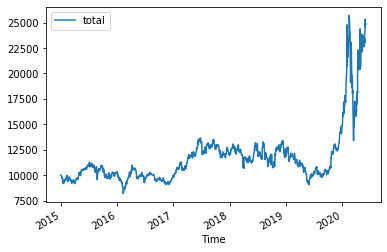

In [130]:
honly_df.plot(x='Time',y='total')

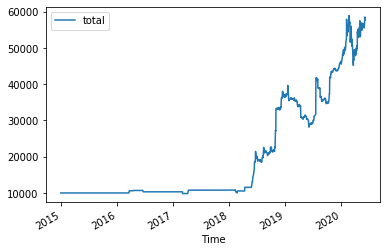

In [187]:
bnh_df.plot(x='Time',y='total')

Need to write a function to tune the hyper-parameters of our trading algorithm.

In [132]:
def tune_trading_algo(tsla_df,anomaly_only_df,start_date,end_date):
    #parameters
    timezone = pytz.timezone('UTC')
    #start_date = timezone.localize(datetime.datetime(2015,1,1))
    #end_date = timezone.localize(datetime.datetime(2020,2,1))
    pos_lims = np.linspace(0.,1.,11)
    neg_lims = np.linspace(0.,1.,11)
    buy_delays = np.linspace(1,10,10)*86400. # delay time in seconds
    sell_delays = np.linspace(1,10,10)*86400. # delay time in seconds
    pos_rules = ['buy','nothing','sell']
    neu_rules = ['buy','nothing','sell']
    neg_rules = ['buy','nothing','sell']
    #convert dataframes to numpy input
    tsla_np,anomaly_only_np,sell_delay,buy_delay,start_time,end_time = \
            convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                        datetime.timedelta(days=1),datetime.timedelta(days=1))
    #array for output
    #use fractional performance as the test metric
    output = np.zeros([11,11,10,10,3,3,3],np.double)
    for i in range(len(pos_lims)):
        for j in range(len(neg_lims)):
            for k in range(len(buy_delays)):
                for l in range(len(sell_delays)):
                    for m in range(len(pos_rules)):
                        for n in range(len(neu_rules)):
                            for o in range(len(neg_rules)):
                                #print (i,j,k,l,m,n,o)
                                #print (pl,nl,buy_d,sell_d,posr,neur,negr,start_time)
                                temp1,temp2 = asset_strategy_calculation_numpy\
                                                        (pos_lims[i],neg_lims[j],5000.,5000.,\
                                                        buy_delays[k],sell_delays[l],anomaly_only_np,\
                                                        tsla_np,start_time,end_time,pos_rules[m],\
                                                        neu_rules[n],neg_rules[o])
                                output[i,j,k,l,m,n,o] = temp1[-1,5] #this is the final fractional performance
                                
    return output

In [133]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
algo_performance = tune_trading_algo(tsla_df,anomaly_only_df,start_date,end_date)

<ipython-input-124-aa8e7bfac23e>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


In [134]:
np.amax(algo_performance)

2.3368606359880078

In [177]:
np.argwhere(np.amax(algo_performance) == algo_performance)[0]

array([0, 2, 8, 1, 0, 2, 0])

Generate the optimized trading data set.

In [140]:
poslim = 0.
neglim = .2
buy_delay = 9.*86400
sell_delay = 2.*86400
rule_pos = 'buy'
rule_neu = 'sell'
rule_neg = 'buy'
bnh,honly = asset_strategy_calculation_numpy(poslim,neglim,init_position,init_capital,\
                                    buy_delay,sell_delay,anomaly_only_np,\
                                    tsla_np,start_time,end_time,rule_pos,\
                                    rule_neu,rule_neg)
bnh_df = pd.DataFrame(data=bnh,    # values
                     index=range(len(bnh[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative'])
honly_df = pd.DataFrame(data=honly,    # values
                     index=range(len(honly[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative'])
#restore the datetime data
bnh_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in bnh[:,0] ])
honly_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in honly[:,0] ])

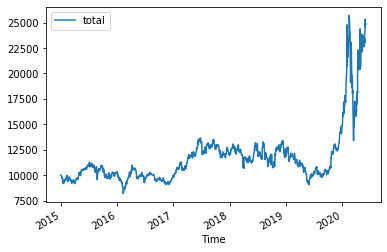

In [141]:
honly_df.plot(x='Time',y='total')

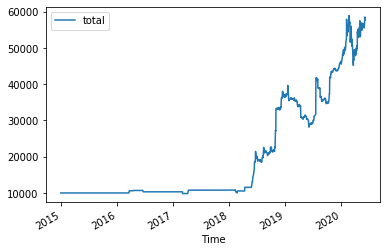

In [142]:
bnh_df.plot(x='Time',y='total')

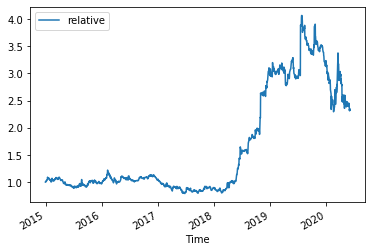

In [143]:
bnh_df.plot(x='Time',y='relative')

Now we need to verify that our identified anomalies are not random.  We will compare our strategy to about one thousand that are run with randomly identified tweets as the 'anomalies'.  The the distribution of the random tweet performance will tell us how well the selected tweets that we have actually track the tweets which impacted the stock price of Tesla.

In [146]:
def test_random_tweets(tsla_df,anomalies_df):
    #from previous results: 
    timezone = pytz.timezone('UTC')
    start_date = timezone.localize(datetime.datetime(2015,1,1))
    end_date = timezone.localize(datetime.datetime(2020,2,1))
    pos_lims = 0.
    neg_lims = .2
    buy_delays = 9.*86400
    sell_delays = 2.*86400
    pos_rules = 'buy'
    neu_rules = 'sell'
    neg_rules = 'buy'
    #create initial array to old the output of each run
    final_results = np.array([])
    for i in range(1000):#do one thousand samples
        #make fake list of anomalies from real tweets
        #using the real sentiment values from each
        anomaly_only_df = anomalies_df.sample(98).sort_values(by=['stock_time'])
        #convert dataframes to numpy input
        tsla_np,anomaly_only_np,dummy1,dummy2,start_time,end_time = \
                convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                            datetime.timedelta(days=1),datetime.timedelta(days=1))
        #uncomment these lines for true random buy/sell orders
        run1,temp1 = asset_strategy_calculation_numpy\
                                            (pos_lims,neg_lims,5000.,5000.,\
                                            buy_delays,sell_delays,anomaly_only_np,\
                                            tsla_np,start_time,end_time,pos_rules,\
                                            neu_rules,neg_rules,rand_flag = True)
#         run1,temp1 = asset_strategy_calculation_numpy\
#                                             (pos_lims,neg_lims,5000.,5000.,\
#                                             buy_delays,sell_delays,anomaly_only_np,\
#                                             tsla_np,start_time,end_time,pos_rules,\
#                                             neu_rules,neg_rules)
        if final_results.shape == (0,):#if this is the first run through
            final_results = run1.reshape(1,run1.shape[0],run1.shape[1])
        else:#stack the results into a single numpy array
            final_results = np.vstack((run1.reshape(1,run1.shape[0],run1.shape[1]),final_results))
    return final_results
            

In [147]:
thousand_realizations = test_random_tweets(tsla_df,anomalies_df)

In [29]:
#fix commenting above for true random trading before running this cell
true_random_realizations = test_random_tweets(tsla_df,anomalies_df)

In [148]:
# Same strategy, randomly picked tweets
print (np.amax(thousand_realizations[:,-1,4]))
print (np.amin(thousand_realizations[:,-1,4]))
print (np.median(thousand_realizations[:,-1,4]))
print (np.mean(thousand_realizations[:,-1,4]))
print (np.sqrt(np.var(thousand_realizations[:,-1,4])))

47077.51051996042
14720.46105009205
24428.81140794832
25017.591804011157
5030.912144453012


In [33]:
# True Random Strategy
print (np.amax(true_random_realizations[:,-1,4]))
print (np.amin(true_random_realizations[:,-1,4]))
print (np.median(true_random_realizations[:,-1,4]))
print (np.mean(true_random_realizations[:,-1,4]))
print (np.sqrt(np.var(true_random_realizations[:,-1,4])))

68058.70921587099
11108.329935891898
25828.847843440526
26801.40380926188
7099.5039530010445


In [149]:
np.amax(bnh[-1,4])

57949.601324062925

In [154]:
np.amax(thousand_realizations[:,-1,4])

47077.51051996042

In [155]:
np.save('../data/raw/thousand_realizations.npy',thousand_realizations)

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

(0, 1)

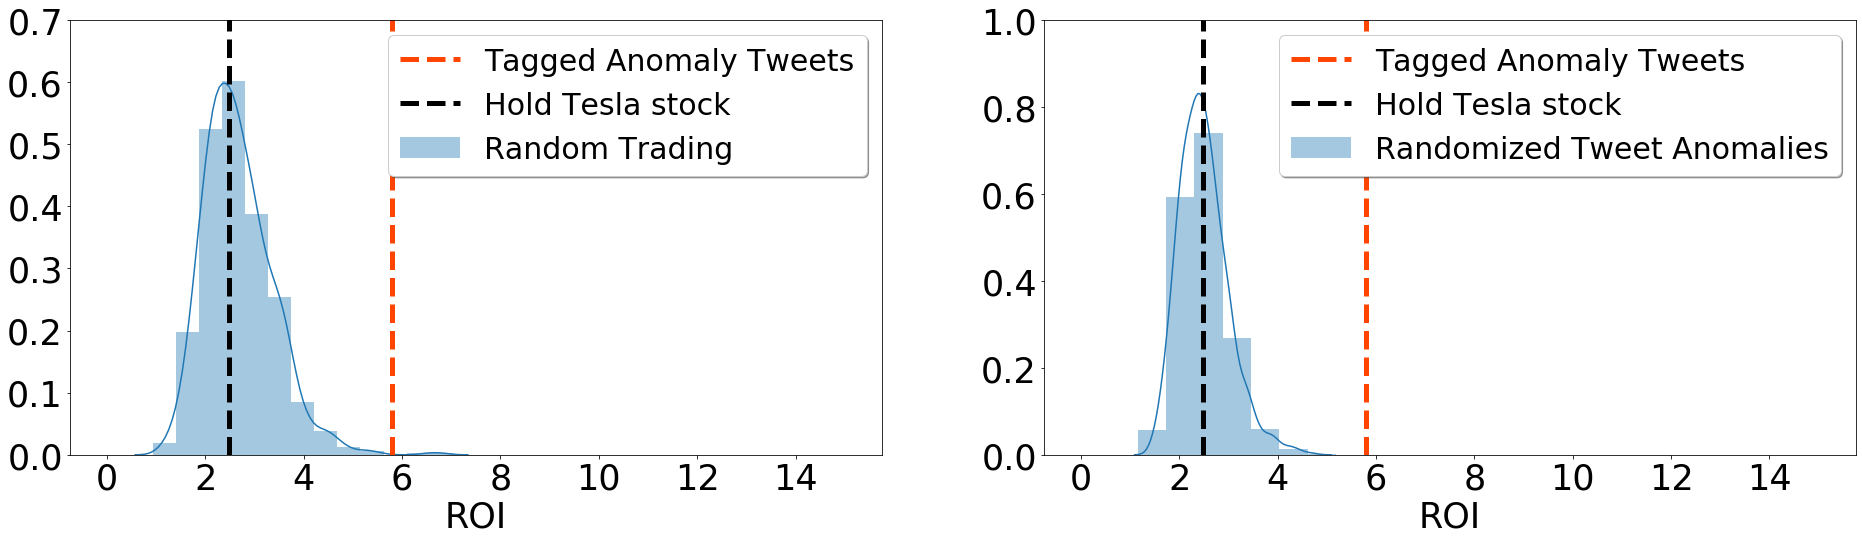

In [153]:
fig, ax = plt.subplots(1,2,figsize=(32,8))
#sbn.distplot(y.dropna(),ax=ax[1],kde=True,rug=True,bins=200,kde_kws={'clip':(0,100)},color='steelblue',label='Wide NN')
sns.distplot(thousand_realizations[:,-1,4]/1.e4,ax=ax[1],rug=False,
             label='Randomized Tweet Anomalies',hist_kws={'range': (0.0, 15.)})
sns.distplot(true_random_realizations[:,-1,4]/1.e4,ax=ax[0],rug=False,
             label='Random Trading',hist_kws={'range': (0.0, 15.)})
x = true_random_realizations[:,-1,4] #just need some dummy variables
ax[0].plot(5.79*np.ones([len(x)]),np.linspace(0,1,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[1].plot(5.79*np.ones([len(x)]),np.linspace(0,1,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[0].plot(2.480*np.ones([len(x)]),np.linspace(0,1,len(x)),lw = 5,ls='--',label='Hold Tesla stock',color='black')
ax[1].plot(2.480*np.ones([len(x)]),np.linspace(0,1,len(x)),lw = 5,ls='--',label='Hold Tesla stock',color='black')
ax[0].legend(loc='upper right', shadow=True,prop={'size': 30})
ax[1].legend(loc='upper right', shadow=True,prop={'size': 30})
ax[0].set_xlabel("ROI",fontsize=35)
ax[1].set_xlabel("ROI",fontsize=35)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
ax[0].set_ylim(0,.7)
ax[1].set_ylim(0,1)



In [156]:
#The fraction of randomly assigned tweet anomaly models that are outperformed by the tagged tweets
print ("tweet anomaly performance = ",1.-len(np.where(thousand_realizations[:,-1,4] > np.amax(bnh[-1,4]))[0])/1000.)
#The fraction of random trading models that are outperformed by the tagged tweets
print ("Random trading performance = ",1.-len(np.where(true_random_realizations[:,-1,4] > np.amax(bnh[-1,4]))[0])/1000.)

tweet anomaly performance =  1.0
Random trading performance =  0.998


## I don't believe how well that model performed.  We're going to have to streamline some of the parameters to optimize EVERY randomly generated tagged tweet set.

In [310]:
def tune_trading_algo_alternate(tsla_df,anomaly_only_df,start_date,end_date):
    #parameters
    timezone = pytz.timezone('UTC')
    #start_date = timezone.localize(datetime.datetime(2015,1,1))
    #end_date = timezone.localize(datetime.datetime(2015,1,1))
    pos_lims = np.linspace(0.,1.,6)
    neg_lims = np.linspace(0.,1.,6)
    buy_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    sell_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    pos_rules = ['buy','sell']
    neu_rules = ['buy','sell']
    neg_rules = ['buy','sell']
    #convert dataframes to numpy input
    tsla_np,anomaly_only_np,sell_delay,buy_delay,start_time,end_time = \
            convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                        datetime.timedelta(days=1),datetime.timedelta(days=1))
    #array for output
    #use fractional performance as the test metric
    output = np.zeros([len(pos_lims),len(neg_lims),2,2,2,2],np.double)
    for i in range(len(pos_lims)):
        for j in range(len(neg_lims)):
    #for k in range(len(buy_delays)):
        #for l in range(len(sell_delays)):
            for m in range(2):
                for n in range(2):
                    for o in range(2):
                        #print (i,j,k,l,m,n,o)
                        #print (pl,nl,buy_d,sell_d,posr,neur,negr,start_time)
                        temp1,temp2 = asset_strategy_calculation_numpy\
                                                (pos_lims[i],neg_lims[j],5000.,5000.,\
                                                buy_delays,sell_delays,anomaly_only_np,\
                                                tsla_np,start_time,end_time,pos_rules[m],\
                                                neu_rules[n],neg_rules[o])
                        #this is the total value in index 1 and trade success rate in index 2
                        output[i,j,m,n,o,:] = [temp1[-1,4],sum(temp1[:,6])/sum(temp1[:,7])] 
                                
    return output

In [290]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2015,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
algo_performance_alternate = tune_trading_algo_alternate(tsla_df,anomaly_only_df,start_date,end_date)

<ipython-input-283-315a42f41542>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


In [291]:
print("max ROI = ",np.argwhere(np.amax(algo_performance_alternate[:,:,:,:,:,0]) ==\
                               algo_performance_alternate[:,:,:,:,:,0]),
                               np.amax(algo_performance_alternate[:,:,:,:,:,0]/1.e4))
print("max Success Rate = ",np.argwhere(np.amax(algo_performance_alternate[:,:,:,:,:,1]) ==\
                               algo_performance_alternate[:,:,:,:,:,1]),
                               np.amax(algo_performance_alternate[:,:,:,:,:,1]))

max ROI =  [[6 3 0 1 0]] 3.251420927199886
max Success Rate =  [[6 2 0 1 0]] 0.723404255319149


In [307]:
algo_performance_alternate[:,:,:,:,:,0].shape

(11, 11, 2, 2, 2)

In [278]:
print(np.amin(algo_performance_alternate[:,:,:,:,:,1]))

0.9852251407129456


In [295]:
poslim = 0.6
neglim = .3
buy_delay = 1.*86400
sell_delay = 1.*86400
rule_pos = 'buy'
rule_neu = 'sell'
rule_neg = 'buy'
#convert dataframes to numpy input
tsla_np,anomaly_only_np,dummy1,dummy2,start_time,end_time = \
        convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                    datetime.timedelta(days=1),datetime.timedelta(days=1))
bnh,honly = asset_strategy_calculation_numpy(poslim,neglim,init_position,init_capital,\
                                    buy_delay,sell_delay,anomaly_only_np,\
                                    tsla_np,start_time,end_time,rule_pos,\
                                    rule_neu,rule_neg)
bnh_df = pd.DataFrame(data=bnh,    # values
                     index=range(len(bnh[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative',
                             'trade_success','trade_executed'])
honly_df = pd.DataFrame(data=honly,    # values
                     index=range(len(honly[:,0])),    # 1st column as index
                     columns=['time_in_sec','num_shares','position','capital','total','relative',
                             'trade_success','trade_executed'])
#restore the datetime data
bnh_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in bnh[:,0] ])
honly_df['Time'] = np.array([start_date+datetime.timedelta(0,time) for time in honly[:,0] ])

<ipython-input-283-315a42f41542>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


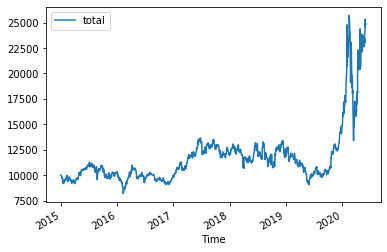

In [296]:
honly_df.plot(x='Time',y='total')

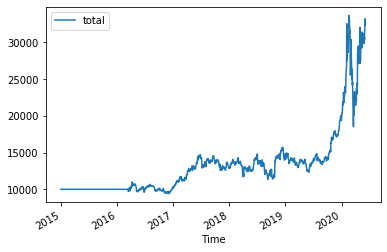

In [297]:
bnh_df.plot(x='Time',y='total')

In [318]:
print("strategy ROI = ",bnh[-1,4]/1.e4)
print("Hold TSLA ROI = ",honly[-1,4]/1.e4)
print("strategy success = ",sum(bnh[:,6]))
print("strategy total = ",sum(bnh[:,7]))

strategy ROI =  3.251420927199886
Hold TSLA ROI =  2.4798056174865666
strategy success =  32.0
strategy total =  47.0


In [299]:
def test_random_tweets_alternate(tsla_df,anomalies_df,rand_flag):
    #from previous results: 
    timezone = pytz.timezone('UTC')
    start_date = timezone.localize(datetime.datetime(2015,1,1))
    end_date = timezone.localize(datetime.datetime(2020,2,1))
    pos_lims = 0.
    neg_lims = 0.
    buy_delays = 1.*86400
    sell_delays = 1.*86400
    pos_rules = 'sell'
    neu_rules = 'sell'
    neg_rules = 'buy'
    #create initial array to old the output of each run
    final_results = np.array([])
    for i in range(1000):#do one thousand samples
        #make fake list of anomalies from real tweets
        #using the real sentiment values from each
        anomaly_only_df = anomalies_df.sample(98).sort_values(by=['stock_time'])
        #convert dataframes to numpy input
        tsla_np,anomaly_only_np,dummy1,dummy2,start_time,end_time = \
                convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                            datetime.timedelta(days=1),datetime.timedelta(days=1))
        #buy and sell orders
        run1,temp1 = asset_strategy_calculation_numpy\
                                            (pos_lims,neg_lims,5000.,5000.,\
                                            buy_delays,sell_delays,anomaly_only_np,\
                                            tsla_np,start_time,end_time,pos_rules,\
                                            neu_rules,neg_rules,rand_flag)

        if final_results.shape == (0,):#if this is the first run through
            final_results = run1.reshape(1,run1.shape[0],run1.shape[1])
        else:#stack the results into a single numpy array
            final_results = np.vstack((run1.reshape(1,run1.shape[0],run1.shape[1]),final_results))
    return final_results

In [300]:
true_random_realizations = test_random_tweets_alternate(tsla_df,anomalies_df,True)

In [311]:
def test_random_tweets_optimize(tsla_df,anomalies_df):
    #from previous results: 
    timezone = pytz.timezone('UTC')
    start_date = timezone.localize(datetime.datetime(2015,1,1))
    end_date = timezone.localize(datetime.datetime(2020,2,1))
    pos_lims = np.linspace(0.,1.,6)
    neg_lims = np.linspace(0.,1.,6)
    buy_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    sell_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    pos_rules = ['buy','sell']
    neu_rules = ['buy','sell']
    neg_rules = ['buy','sell']
    #create initial array to old the output of each run
    final_results = np.array([])
    for i in range(10):#do one thousand samples
        #make fake list of anomalies from real tweets
        #using the real sentiment values from each
        anomaly_only_df = anomalies_df.sample(98).sort_values(by=['stock_time'])
        #convert dataframes to numpy input
        tsla_np,anomaly_only_np,dummy1,dummy2,start_time,end_time = \
                convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                            datetime.timedelta(days=1),datetime.timedelta(days=1))
        algo_opt = tune_trading_algo_alternate(tsla_df,anomaly_only_df,start_date,end_date)
        #indices of the tuning parameters that produce the best ROI performance
        op_i = np.argwhere(np.amax(algo_opt[:,:,:,:,:,0]) == algo_opt[:,:,:,:,:,0])[0]
        #uncomment these lines for true random buy/sell orders
        run1,temp1 = asset_strategy_calculation_numpy\
                                            (pos_lims[op_i[0]],neg_lims[op_i[1]],5000.,5000.,\
                                            buy_delays,sell_delays,anomaly_only_np,\
                                            tsla_np,start_time,end_time,pos_rules[op_i[2]],\
                                            neu_rules[op_i[3]],neg_rules[op_i[4]],rand_flag = False)
        if final_results.shape == (0,):#if this is the first run through
            final_results = run1.reshape(1,run1.shape[0],run1.shape[1])
        else:#stack the results into a single numpy array
            final_results = np.vstack((run1.reshape(1,run1.shape[0],run1.shape[1]),final_results))
    return final_results

In [ ]:
%timeit random_tweets_optimized_realizations = test_random_tweets_optimize(tsla_df,anomalies_df)

(0, 3.0)

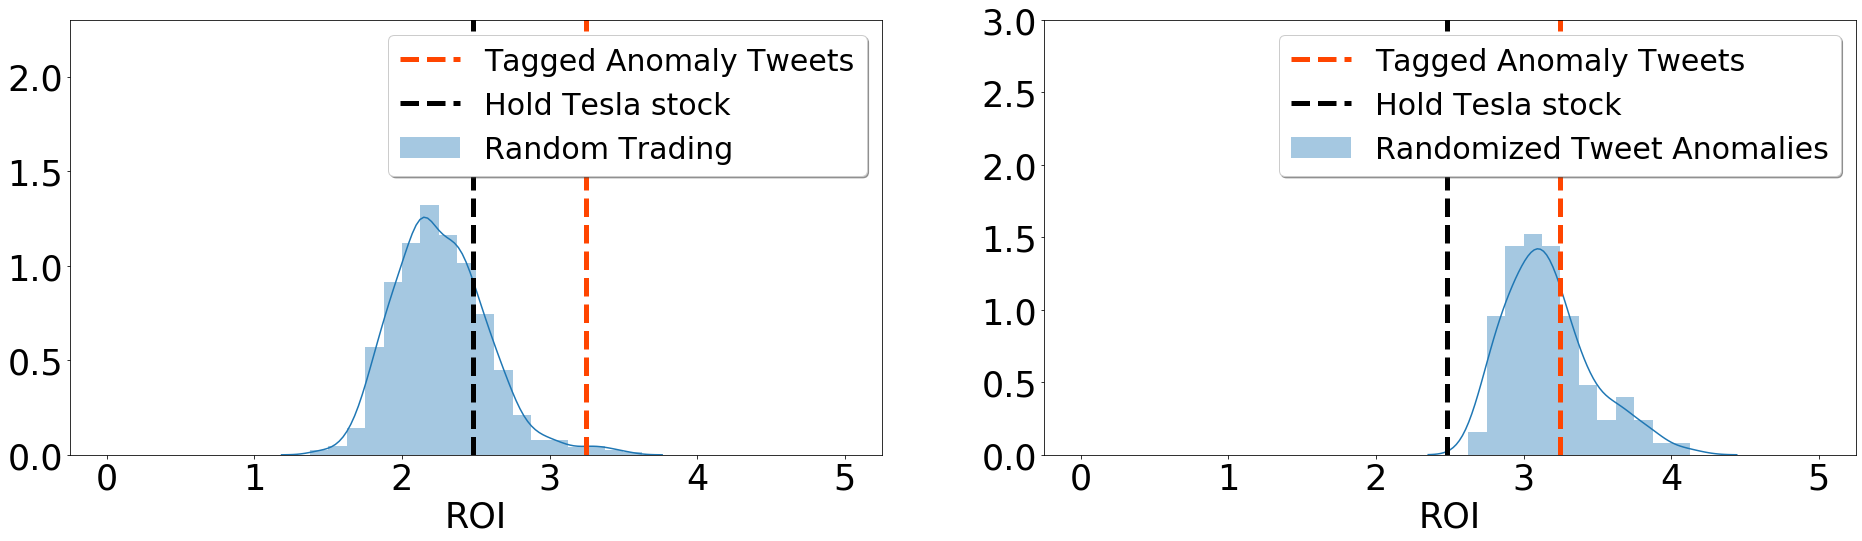

In [344]:
fig, ax = plt.subplots(1,2,figsize=(32,8))
#sbn.distplot(y.dropna(),ax=ax[1],kde=True,rug=True,bins=200,kde_kws={'clip':(0,100)},color='steelblue',label='Wide NN')
sns.distplot(random_tweets_optimized_realizations[:,-1,4]/1.e4,ax=ax[1],rug=False,
             label='Randomized Tweet Anomalies',hist_kws={'range': (1., 5.)},bins = 40)
sns.distplot(true_random_realizations[:,-1,4]/1.e4,ax=ax[0],rug=False,
             label='Random Trading',hist_kws={'range': (1., 5.)},bins = 40)
x = true_random_realizations[:,-1,4] #just need some dummy variables
ax[0].plot(3.25*np.ones([len(x)]),np.linspace(0,10,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[1].plot(3.25*np.ones([len(x)]),np.linspace(0,10,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[0].plot(2.48*np.ones([len(x)]),np.linspace(0,10,len(x)),lw = 5,ls='--',label='Hold Tesla stock',color='black')
ax[1].plot(2.48*np.ones([len(x)]),np.linspace(0,10,len(x)),lw = 5,ls='--',label='Hold Tesla stock',color='black')
ax[0].legend(loc='upper right', shadow=True,prop={'size': 30})
ax[1].legend(loc='upper right', shadow=True,prop={'size': 30})
ax[0].set_xlabel("ROI",fontsize=35)
ax[1].set_xlabel("ROI",fontsize=35)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
ax[0].set_ylim(0,2.3)
ax[1].set_ylim(0,3.)

In [314]:
#The fraction of randomly assigned tweet anomaly models that are outperformed by the tagged tweets
print ("tweet anomaly performance = ",1.-len(np.where(random_tweets_optimized_realizations[:,-1,4] > np.amax(bnh[-1,4]))[0])/100.)
#The fraction of random trading models that are outperformed by the tagged tweets
print ("Random trading performance = ",1.-len(np.where(true_random_realizations[:,-1,4] > np.amax(bnh[-1,4]))[0])/1000.)

tweet anomaly performance =  0.7
Random trading performance =  0.989


In [323]:
np.sum(random_tweets_optimized_realizations[:,:,7],axis=1).mean()

68.04

(0, 15)

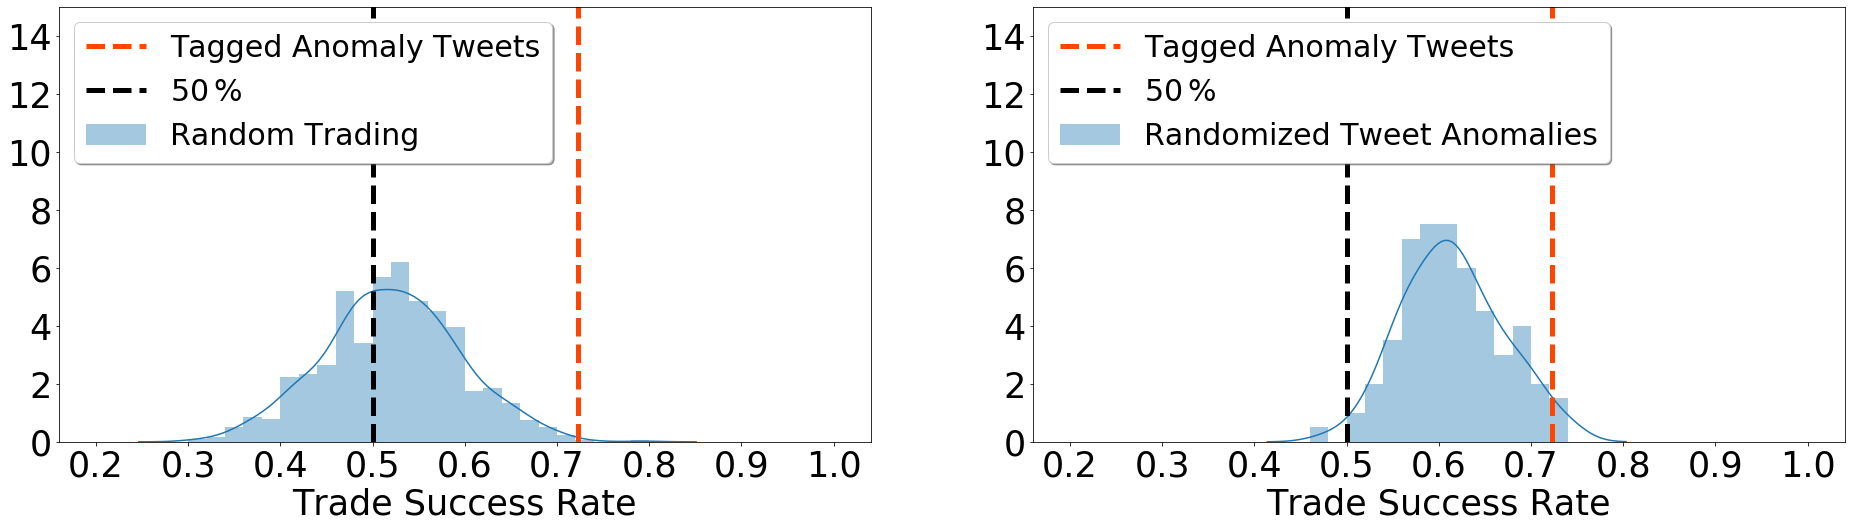

In [334]:
fig, ax = plt.subplots(1,2,figsize=(32,8))
optimized_success_rate = np.sum(random_tweets_optimized_realizations[:,:,6],axis=1)/\
                         np.sum(random_tweets_optimized_realizations[:,:,7],axis=1)
random_success_rate =np.sum(true_random_realizations[:,:,6],axis=1)/\
                         np.sum(true_random_realizations[:,:,7],axis=1)
#sbn.distplot(y.dropna(),ax=ax[1],kde=True,rug=True,bins=200,kde_kws={'clip':(0,100)},color='steelblue',label='Wide NN')
sns.distplot(optimized_success_rate,ax=ax[1],rug=False,
             label='Randomized Tweet Anomalies',hist_kws={'range': (.2, 1.)},bins = 40)
sns.distplot(random_success_rate,ax=ax[0],rug=False,
             label='Random Trading',hist_kws={'range': (.2, 1.)},bins = 40)
x = true_random_realizations[:,-1,4] #just need some dummy variables
ax[0].plot(.723*np.ones([len(x)]),np.linspace(0,100,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[1].plot(.723*np.ones([len(x)]),np.linspace(0,100,len(x)),lw = 5,ls='--',label='Tagged Anomaly Tweets',color='orangered')
ax[0].plot(.5*np.ones([len(x)]),np.linspace(0,100,len(x)),lw = 5,ls='--',label=r'$50\,\%$',color='black')
ax[1].plot(.5*np.ones([len(x)]),np.linspace(0,100,len(x)),lw = 5,ls='--',label=r'$50\,\%$',color='black')
ax[0].legend(loc='upper left', shadow=True,prop={'size': 30})
ax[1].legend(loc='upper left', shadow=True,prop={'size': 30})
ax[0].set_xlabel("Trade Success Rate",fontsize=35)
ax[1].set_xlabel("Trade Success Rate",fontsize=35)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
ax[0].set_ylim(0,15)
ax[1].set_ylim(0,15)

In [340]:
len(np.where(optimized_success_rate[:] > .723)[0])

3

In [341]:
#The fraction of randomly assigned tweet anomaly models that are outperformed by the tagged tweets
print ("tweet anomaly performance = ",1.-len(np.where(optimized_success_rate[:] > .723)[0])/100.)
#The fraction of random trading models that are outperformed by the tagged tweets
print ("Random trading performance = ",1.-len(np.where(random_success_rate[:] > .723)[0])/1000.)



tweet anomaly performance =  0.97
Random trading performance =  0.998
